In [6]:
from matplotlib import pyplot as plt
import numpy as np
import joblib
import os
import pandas as pd

In [7]:
def load_bugsense_data():
    data = pd.read_csv('/media/storage/users/go98kef/TimeSeriesConversion/time_series_data.csv', header=None)
    labels = pd.read_csv('/media/storage/users/go98kef/TimeSeriesConversion/time_series_labels.csv', header=None)

    # Calculate number of complete groups of 80
    n_samples = len(data) // 80

    # Reshape data into groups of 80
    data_grouped = data.values.reshape(n_samples, 80, 24).transpose(0, 2, 1)
    labels_grouped = labels.values[::80]  # Take every 80th label

    # Generate random split indices (70% train, 30% test)
    train_size = int(0.7 * n_samples)
    indices = np.random.permutation(n_samples)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    # Split data and labels
    X_train = data_grouped[train_indices]
    X_test = data_grouped[test_indices]
    y_train = labels_grouped[train_indices]
    y_test = labels_grouped[test_indices]

    return X_train, y_train.squeeze(), X_test, y_test.squeeze()

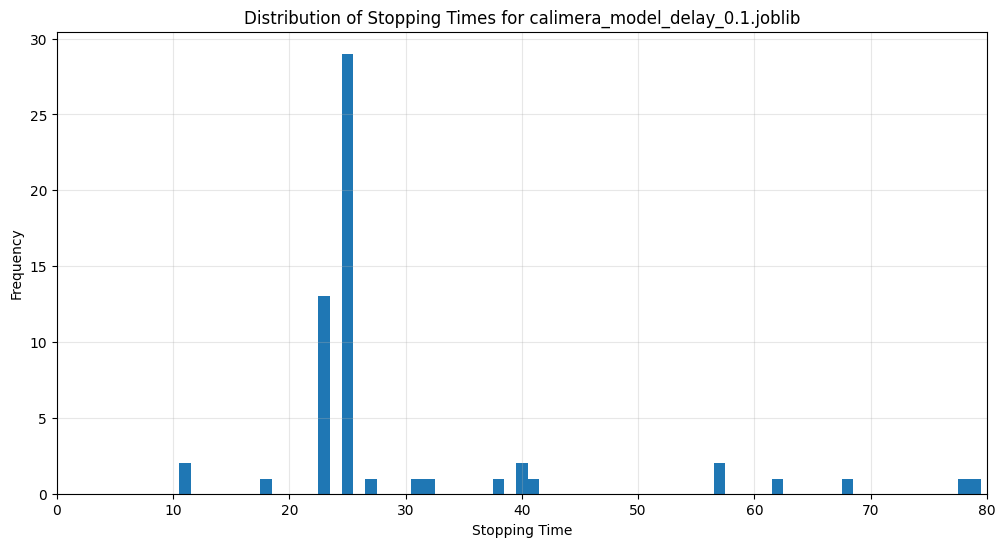

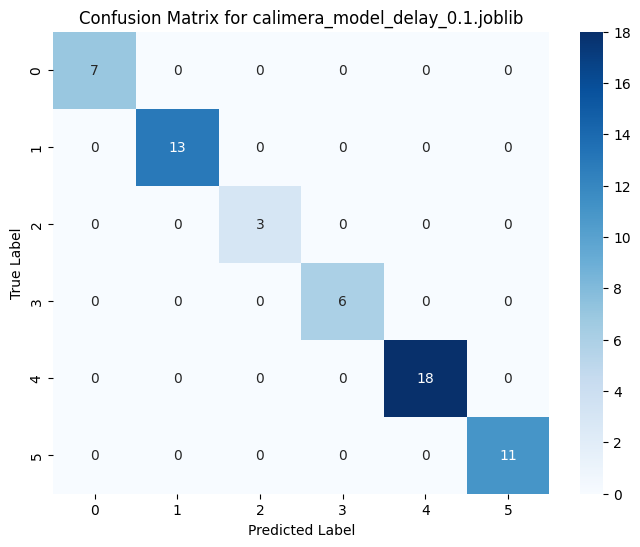

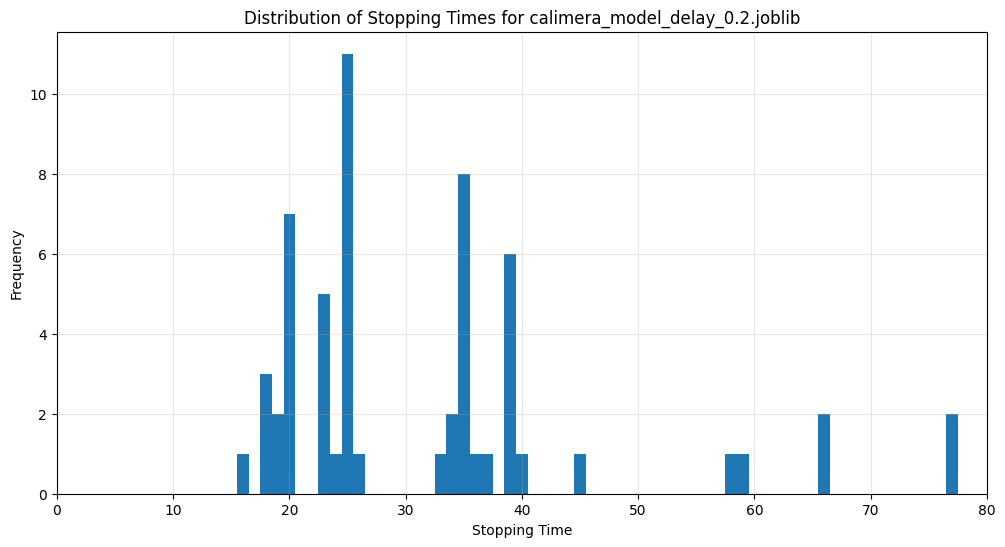

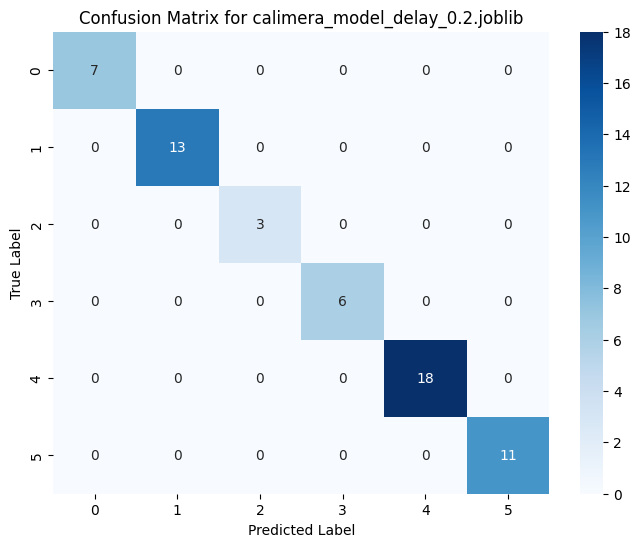

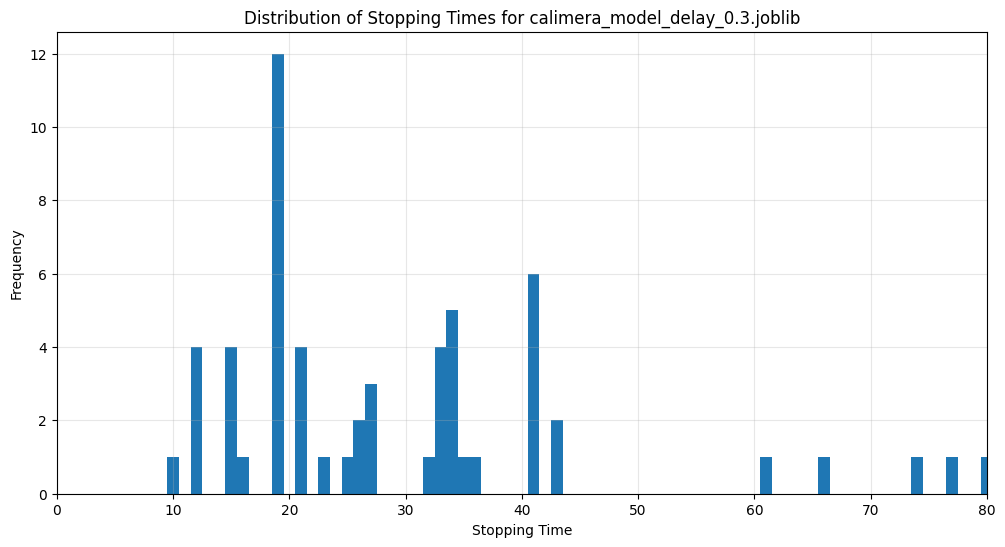

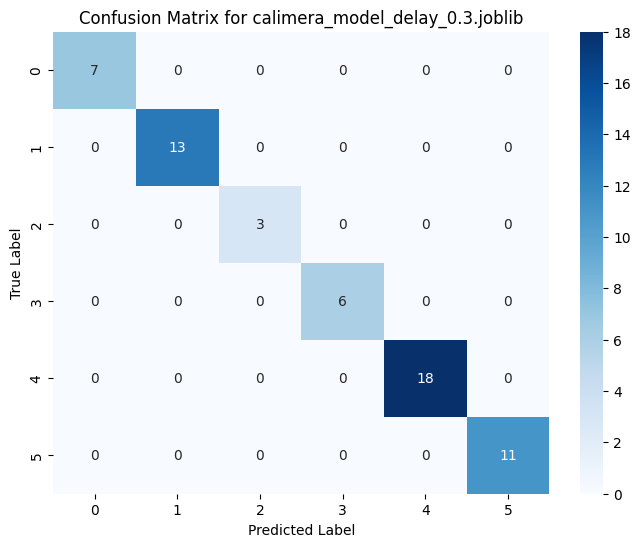

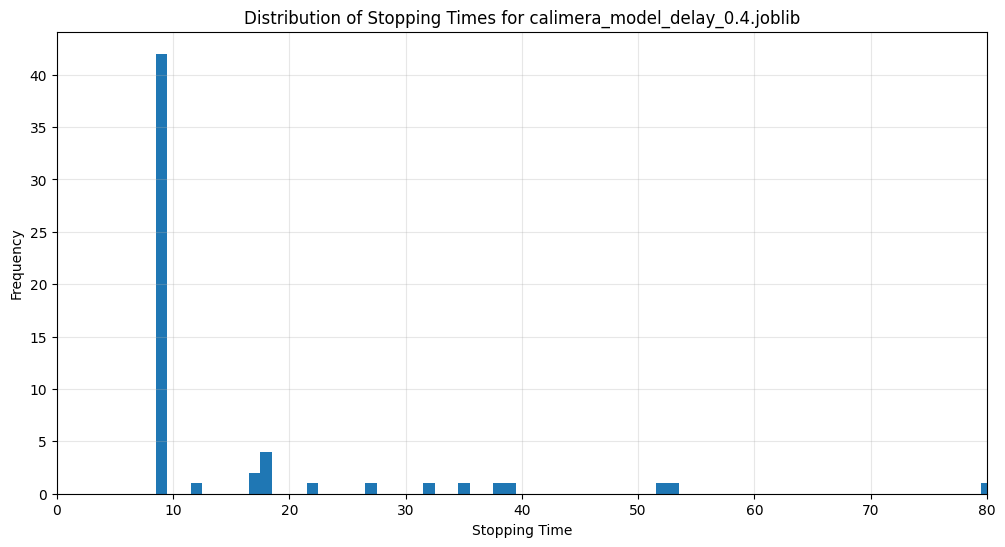

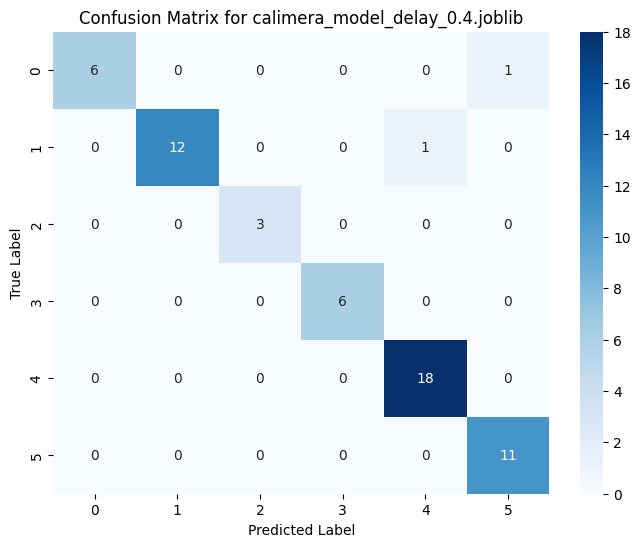

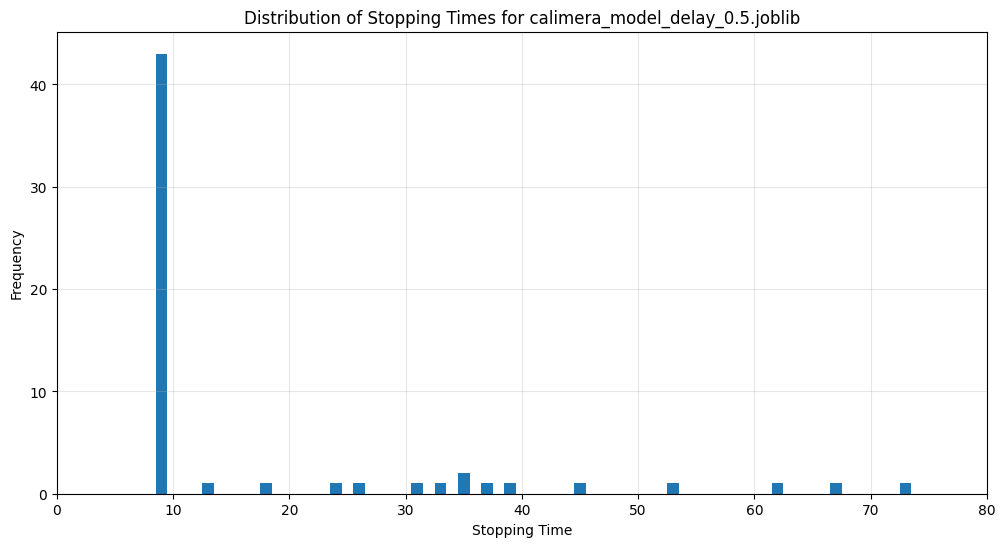

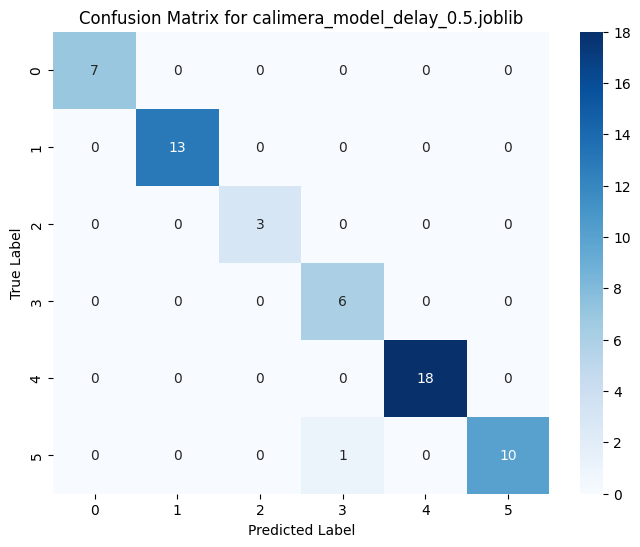

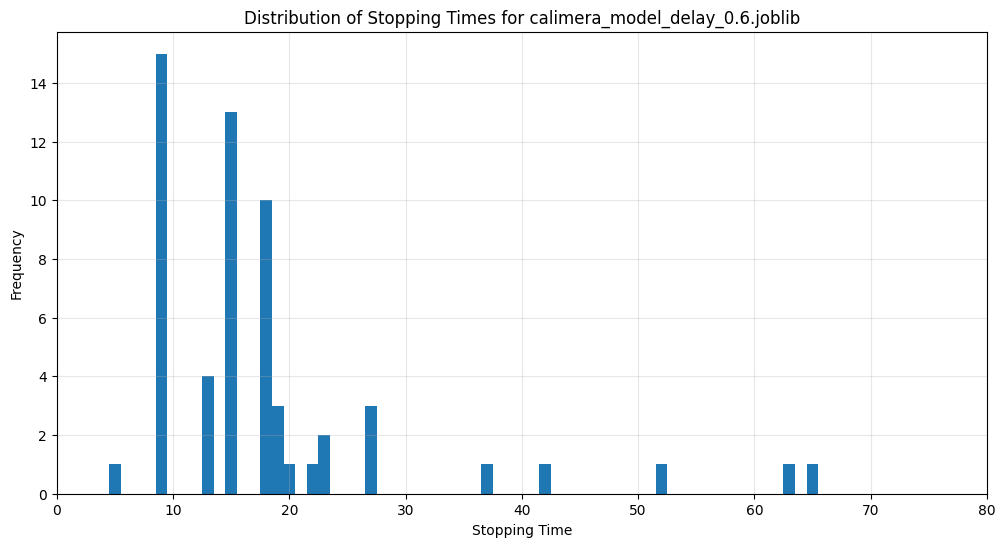

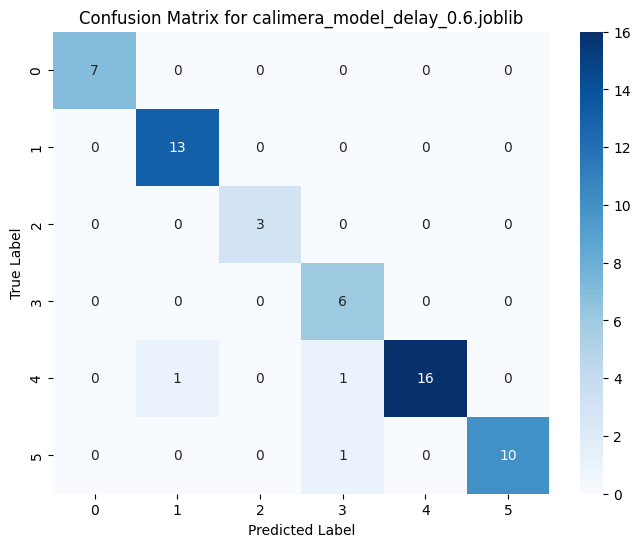

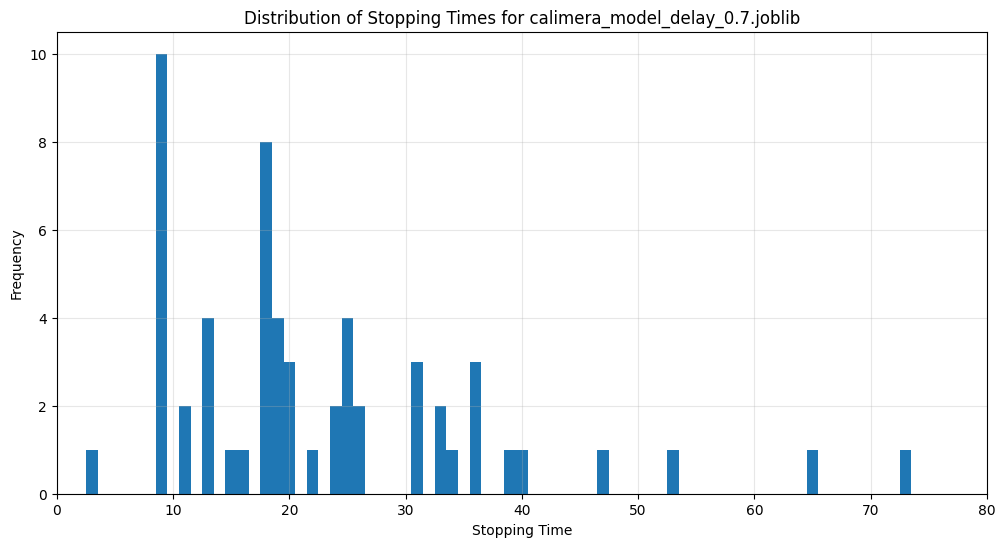

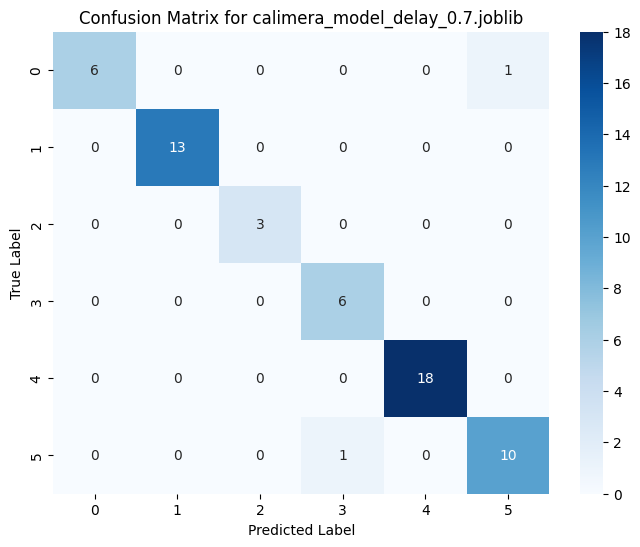

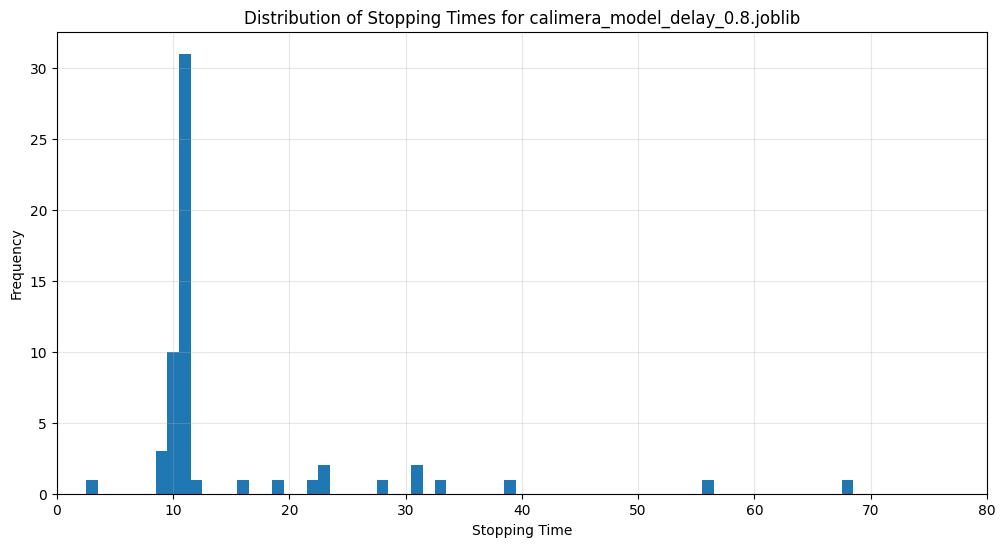

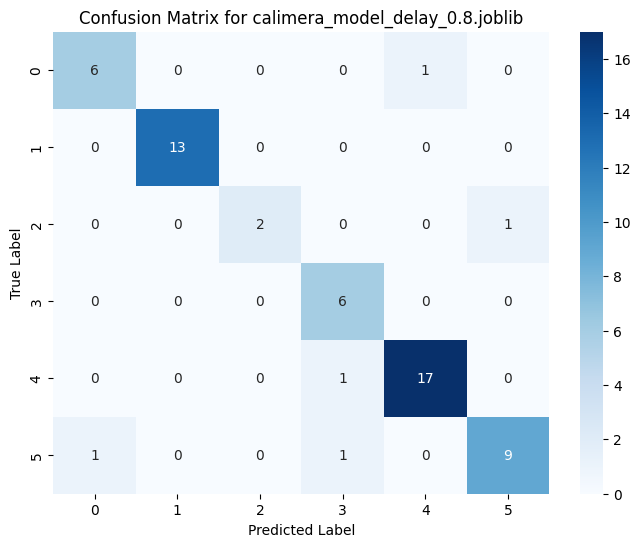

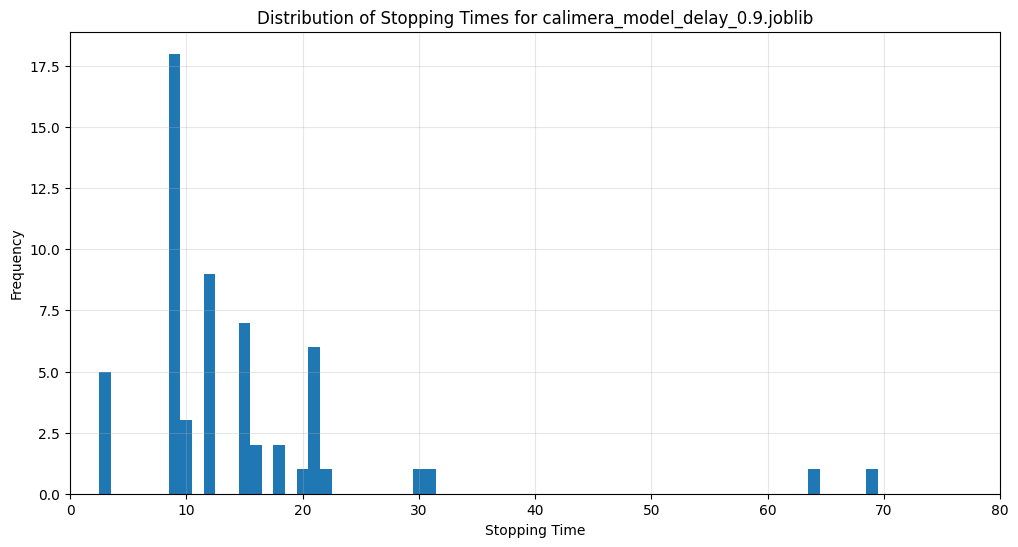

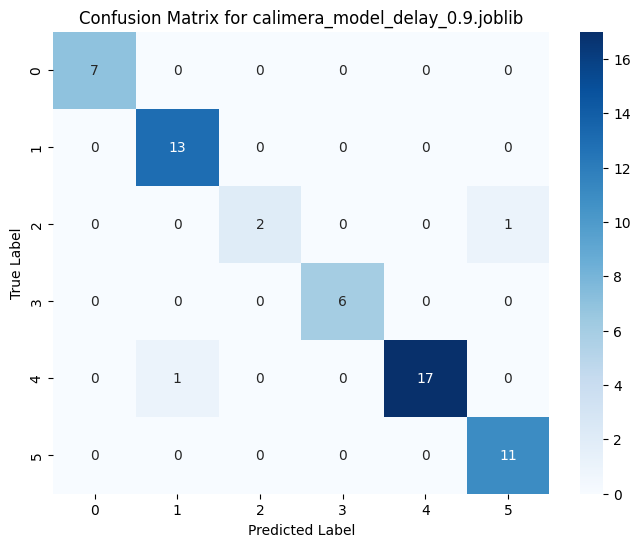

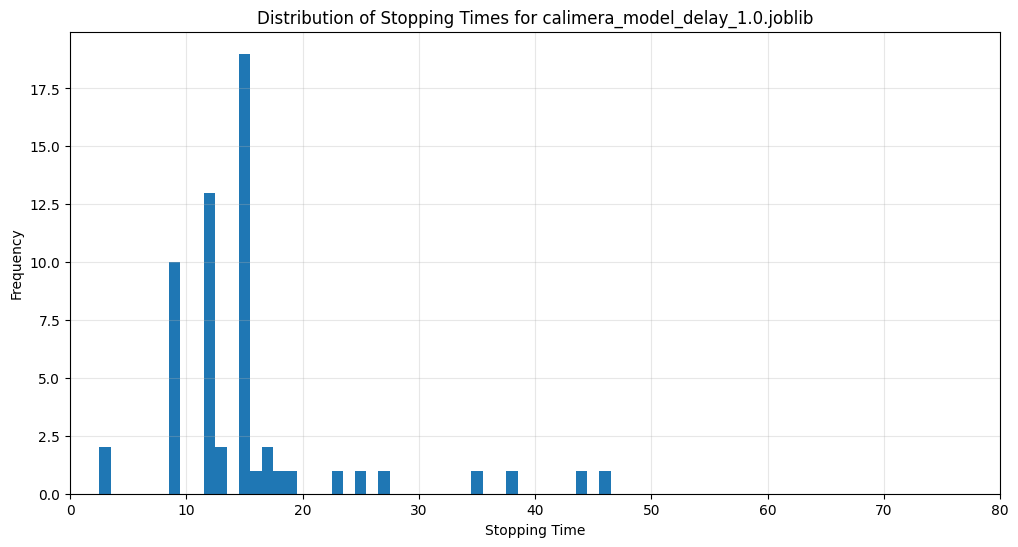

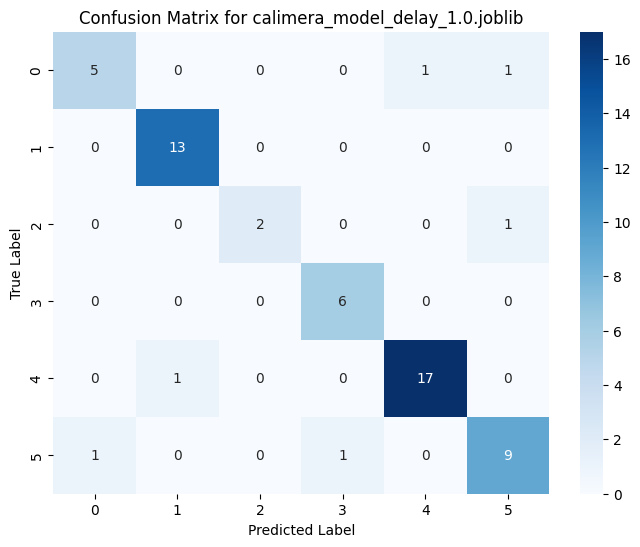

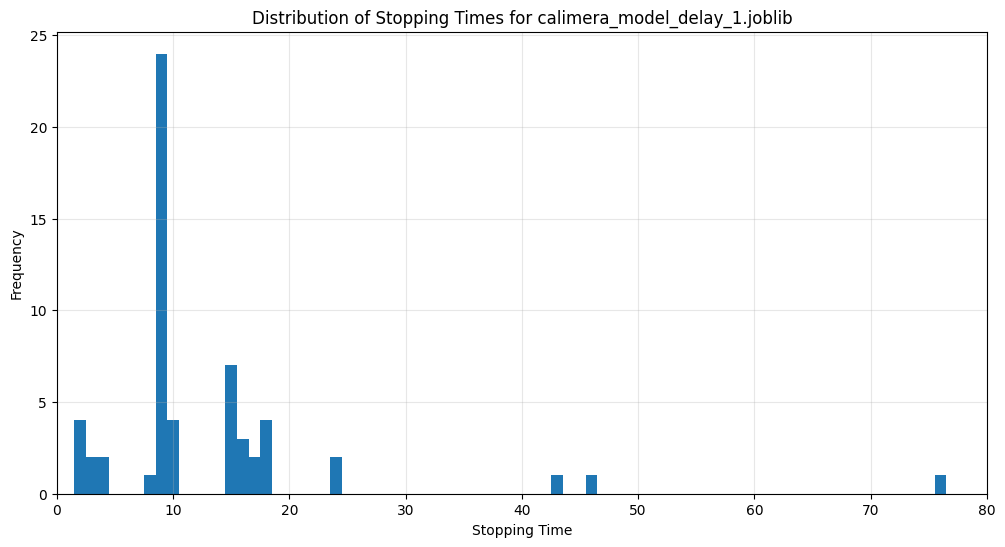

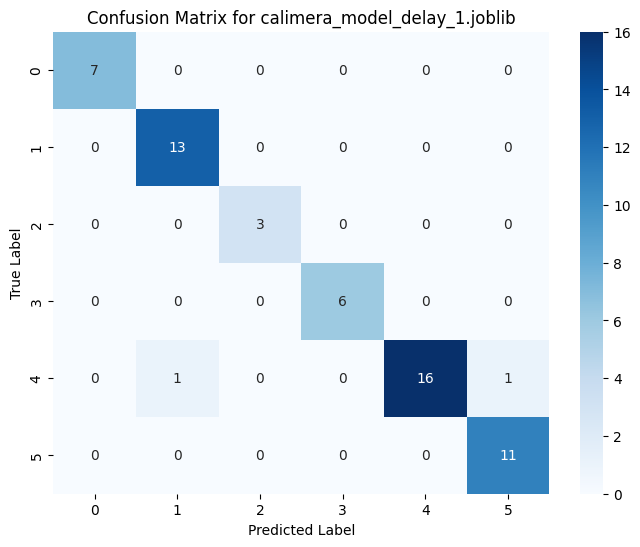

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import numpy as np


models = [f for f in os.listdir('/media/storage/users/go98kef/CALIMERA/saved_models') if f.endswith('.joblib')]
X_train, y_train, X_test, y_test = load_bugsense_data()
root = '/media/storage/users/go98kef/CALIMERA/saved_models'
# Sort models based on the float delay number in the filename
models.sort(key=lambda x: float(x.split('_')[3].replace('delay_', '').replace('.joblib', '')))

m = 0
for model in models:
    model = joblib.load(os.path.join(root, model))
    stop_timestamps, y_pred = model.test(X_test)
    # Create histogram of stopping times
    plt.figure(figsize=(12, 6))
    plt.hist(stop_timestamps, bins=range(1, 82), align='left')  # 81 bins for values 1-80
    plt.title(f'Distribution of Stopping Times for {models[m]}')
    plt.xlabel('Stopping Time')
    plt.ylabel('Frequency')
    plt.xlim(0, 80)
    plt.grid(True, alpha=0.3)
    plt.show()

    # Create confusion matrix

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {models[m]}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    m += 1

    